<a href="https://colab.research.google.com/github/OUAALOUHOUM/Deep-learning-project/blob/main/Copie_de_Ouaalouhou_CNN_UDA_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.utils import shuffle
from keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import models
from collections import Counter
from tensorflow.keras.utils import to_categorical,Sequence

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)) 
test_images = test_images.astype('float32') / 255
# train_labels = to_categorical(train_labels) 
test_labels = to_categorical(test_labels)


x, y = shuffle(train_images, train_labels, random_state=15)
x_train = x[0:100]
y_train = y[0:100].reshape(-1, 1)
y_train = to_categorical(y_train) 

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(100, 28, 28, 1)

In [4]:
Counter(y[0:100])

Counter({4: 12, 2: 11, 5: 8, 8: 8, 7: 13, 1: 12, 9: 9, 0: 7, 3: 8, 6: 12})

In [5]:
EPOCHES = 100

# Without augmentation

In [6]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

mcp = ModelCheckpoint("/content/baseline_best.h5", monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto')

model.compile(loss='categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                      

In [8]:
history = model.fit(x_train, y_train, validation_data=(test_images, test_labels), epochs=EPOCHES, callbacks=[mcp])

Epoch 1/100
4/4 [==============================] - 23s 1s/step - loss: 3.2294 - accuracy: 0.1400 - val_loss: 2.2843 - val_accuracy: 0.2071
Epoch 2/100
4/4 [==============================] - 1s 305ms/step - loss: 1.8237 - accuracy: 0.4200 - val_loss: 2.2759 - val_accuracy: 0.3882
Epoch 3/100
4/4 [==============================] - 1s 435ms/step - loss: 1.2892 - accuracy: 0.5400 - val_loss: 2.2708 - val_accuracy: 0.1749
Epoch 4/100
4/4 [==============================] - 1s 291ms/step - loss: 1.1368 - accuracy: 0.6200 - val_loss: 2.2659 - val_accuracy: 0.1242
Epoch 5/100
4/4 [==============================] - 1s 435ms/step - loss: 0.7300 - accuracy: 0.7500 - val_loss: 2.2638 - val_accuracy: 0.1207
Epoch 6/100
4/4 [==============================] - 1s 435ms/step - loss: 0.7175 - accuracy: 0.7600 - val_loss: 2.2656 - val_accuracy: 0.1135
Epoch 7/100
4/4 [==============================] - 1s 292ms/step - loss: 0.5207 - accuracy: 0.7800 - val_loss: 2.2674 - val_accuracy: 0.1135
Epoch 8/100
4/4

### best accuracy

In [9]:
#test_model = load_model("/content/baseline_best.h5")
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

313/313 [==============================] - 1s 3ms/step - loss: 3.0266 - accuracy: 0.2217


0.22169999778270721

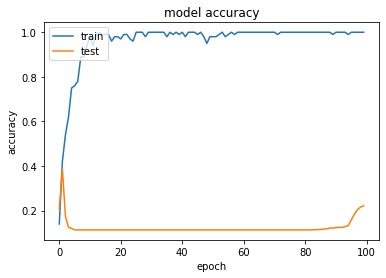

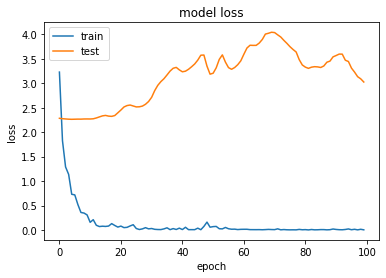

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) #val_accuracy #val_acc
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# With RandAug

In [11]:
!pip install imgaug -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from imgaug import augmenters as iaa

In [13]:
#L'entraînement de l'ensemble des données n'est pas suffisant en mémoire, alors on define un générateur

class generator(Sequence):
    #Appliquer RandAug
    def aug(self,x):
        
        seq = iaa.Sequential([
            iaa.RandAugment(n=3, m=7),
            iaa.Resize({"height": 28, "width": 28})
            ])
        x=seq.augment_images(x)
        #Normalisation, le modèle de pré-entraînement dans keras.applications consiste à normaliser les données à [-1,1],
        # et le modèle de pré-entraînement dans TF hub est de normaliser les données à [0,1]
        x=x.astype('float32')/255
        return x

    def __init__(self, x_set, y_set, batch_size):
        self.x_set , self.y_set = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x_set) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x1 = self.x_set[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y1 = self.y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x1=self.aug(batch_x1)

        return batch_x1,batch_y1
  
    #Cette fonction sera automatiquement exécutée à la fin de chaque époque pendant l'entraînement
    def on_epoch_end(self):
        print("fin d'époque")

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:100]
y_train = y_train[:100]

#mnist doit être converti en une image à 3 canaux
x_train=np.stack((x_train,)*3, axis=-1)
x_test=np.stack((x_test,)*3, axis=-1)

#Un encodage 
y_train=to_categorical(y_train,10)
y_test=to_categorical(y_test,10)


In [15]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(28,28,3)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

mcp = ModelCheckpoint("/content/weights-hub.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto')

model.compile(loss='categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

In [16]:
batchsize=32
g = generator(x_train , y_train , batchsize)

In [17]:
history2 =model.fit_generator(g, 
                    steps_per_epoch=int(x_train.shape[0]/batchsize),
                    epochs= EPOCHES, 
                    # verbose=1, 
                    callbacks=[mcp], 
                    validation_data=(x_test, y_test), 
                    # validation_steps=None, 
                    # class_weight=None, 
                    max_queue_size=10, 
                    workers=2, 
                    use_multiprocessing=False, 
                    shuffle=True
                    #initial_epoch=0
                    )


<ipython-input-17-68ee4d94cc99>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 =model.fit_generator(g,


Epoch 1/100
3/3 [==============================] - 7s 2s/step - loss: 3.9220 - accuracy: 0.1324 - val_loss: 19.3612 - val_accuracy: 0.1880
fin d'époque
Epoch 2/100
3/3 [==============================] - 2s 1s/step - loss: 3.0956 - accuracy: 0.1042 - val_loss: 16.7737 - val_accuracy: 0.2341
fin d'époque
Epoch 3/100
3/3 [==============================] - 2s 1s/step - loss: 2.6598 - accuracy: 0.2206 - val_loss: 27.9131 - val_accuracy: 0.1869
fin d'époque
Epoch 4/100
3/3 [==============================] - 2s 953ms/step - loss: 2.2985 - accuracy: 0.2794 - val_loss: 28.6611 - val_accuracy: 0.1765
fin d'époque
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 2.5891 - accuracy: 0.2941 - val_loss: 32.5489 - val_accuracy: 0.1174
fin d'époque
Epoch 6/100
3/3 [==============================] - 1s 597ms/step - loss: 2.4654 - accuracy: 0.2917 - val_loss: 26.8631 - val_accuracy: 0.1421
fin d'époque
Epoch 7/100
3/3 [==============================] - 1s 673ms/step - loss: 2.4270 - 

## Best accuracy

In [18]:
#test_model = load_model("/content/weights-hub.hdf5")
test_loss, test_acc = model.evaluate(x_test, y_test)
test_acc

313/313 [==============================] - 1s 3ms/step - loss: 29.8700 - accuracy: 0.7526


0.7526000142097473

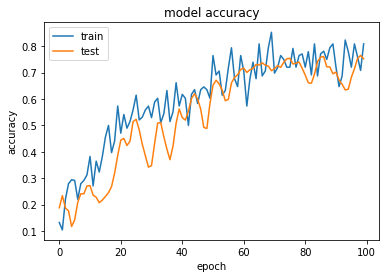

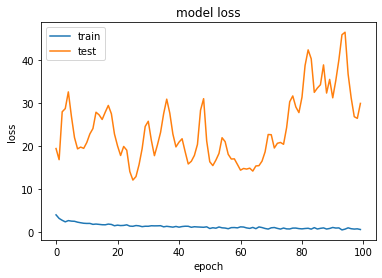

In [19]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# all data

In [20]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)) 
test_images = test_images.astype('float32') / 255
# train_labels = to_categorical(train_labels) 
test_labels = to_categorical(test_labels)


x, y = shuffle(train_images, train_labels, random_state=15)
x_train = x
y_train = y.reshape(-1, 1)
y_train = to_categorical(y_train) 

In [21]:
x_train.shape

(60000, 28, 28, 1)

In [22]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

mcp = ModelCheckpoint("/content/baseline_allData_best.h5", monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto')

model.compile(loss='categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_9 (Activation)   (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                  

In [24]:
history = model.fit(x_train, y_train, validation_data=(test_images, test_labels), epochs=EPOCHES, callbacks=[mcp])

Epoch 1/100
1875/1875 [==============================] - 16s 7ms/step - loss: 0.1646 - accuracy: 0.9514 - val_loss: 0.0464 - val_accuracy: 0.9863
Epoch 2/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0656 - accuracy: 0.9812 - val_loss: 0.0332 - val_accuracy: 0.9892
Epoch 3/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0494 - accuracy: 0.9857 - val_loss: 0.0342 - val_accuracy: 0.9899
Epoch 4/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0418 - accuracy: 0.9884 - val_loss: 0.0362 - val_accuracy: 0.9899
Epoch 5/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0387 - accuracy: 0.9888 - val_loss: 0.0344 - val_accuracy: 0.9896
Epoch 6/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0303 - accuracy: 0.9913 - val_loss: 0.0356 - val_accuracy: 0.9901
Epoch 7/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0276 - accuracy: 0.9925 - val_loss: 0.0329 -

### best accuracy

In [25]:
#test_model = load_model("/content/baseline_allData_best.h5")
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

313/313 [==============================] - 1s 4ms/step - loss: 0.0914 - accuracy: 0.9940


0.9940000176429749

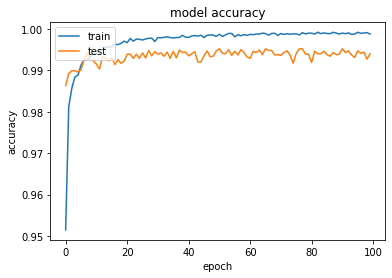

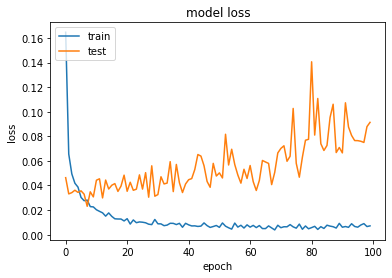

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) #val_accuracy #val_acc
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()